<a href="https://colab.research.google.com/github/nagaraju-urakonda/data-analysis-python/blob/main/twitter_analasis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dropout, Dense, GlobalAveragePooling1D, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve
from sklearn.model_selection import train_test_split

import pickle
import joblib

In [ ]:
train_data =pd.read_csv('/content/twitter_training.csv', names=['number' , 'Border' , 'label' , 'text'] )
test_data =pd.read_csv('/content/twitter_validation.csv', names=['number' , 'Border' , 'label' , 'text'])
train_data.shape, test_data.shape

((74682, 4), (1000, 4))

In [ ]:
train_data.head()


,number,Border,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
train_data.drop(['number', 'Border'], axis= 1, inplace= True)
test_data.drop(['number', 'Border'], axis= 1, inplace= True)
train_data.head()


,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
train_data.isna().sum()

,0
label,0
text,686


In [ ]:
train_data.dropna(axis=0, inplace= True)

In [ ]:
train_data.duplicated().sum()

np.int64(4227)

In [ ]:
train_data.drop_duplicates(inplace= True)

In [ ]:
train_data.shape

(69769, 2)

In [ ]:
train_data['label'].value_counts()

,count
label,
Negative,21237
Positive,19138
Neutral,17110
Irrelevant,12284


<Axes: ylabel='count'>

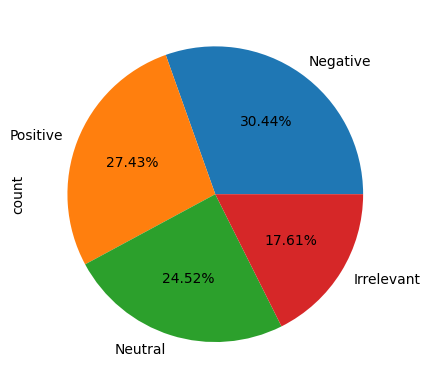

In [ ]:
train_data['label'].value_counts().plot.pie(autopct='%2.2f%%')

In [ ]:
train_data = train_data[train_data['label'].isin(['Positive', 'Negative'])]

In [ ]:
train_data['label'].value_counts()

,count
label,
Negative,21237
Positive,19138


<Axes: ylabel='count'>

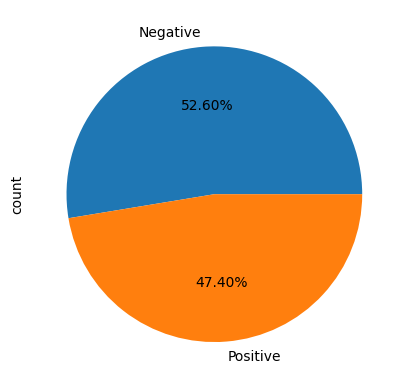

In [ ]:
train_data['label'].value_counts().plot.pie(autopct='%2.2f%%')

In [ ]:
embedding_dim =128
oov_tok ='<OOV>'
training_portion = .8
max_length =150

In [ ]:


train_data['text'][10]

"2010 So I spent a few hours making something for fun. . . If you don't know I am a HUGE RhandlerR fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg"

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
punc =string.punctuation
st_words =stopwords.words('english')
print(st_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer




def clean_text (text):

    text = re.sub('@ ?[\w]+', '', text)
    text = re.sub('https?://\S+|www\.\S+' ,' ',text)
    text = re.sub('\w*gmail.com\b|\w*yahoo.co.in\b' ,' ',text)
    text = re.sub('<.*>', '', text)
    text = re.sub('[\W]',' ', text)
    text = re.sub('[0-9]',' ', text)
    #remove single character
    text = re.sub('\s+[a-zA-Z]\s+',' ', text)
    #removeing multiple spaces
    text = re.sub('\s+',' ', text)

    #tokens = word_tokenize(text)

    text=''.join([word.lower() for word in text if word not in punc])
    text =' '.join([word for word in text.split() if word not in st_words])


    return text



train_data['cleaned_text'] = train_data['text'].apply(lambda x: clean_text(x))

train_data.head(15)

,label,text,cleaned_text
0,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,Positive,I am coming to the borders and I will kill you...,coming borders kill
2,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
4,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
5,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder
6,Positive,So I spent a few hours making something for fu...,spent hours making something fun know huge fan...
7,Positive,So I spent a couple of hours doing something f...,spent couple hours something fun know huge fan...
8,Positive,So I spent a few hours doing something for fun...,spent hours something fun know huge fan maya o...
9,Positive,So I spent a few hours making something for fu...,spent hours making something fun know huge rha...


In [ ]:
from collections import Counter
word_count = Counter()

for text in train_data['cleaned_text']:
    for word in text.split():
        word_count[word] += 1

word_count.most_common(10)

[('game', 6020),
 ('com', 3655),
 ('like', 2943),
 ('pic', 2539),
 ('get', 2537),
 ('twitter', 2390),
 ('really', 2236),
 ('play', 2212),
 ('good', 2133),
 ('one', 2063)]

In [ ]:
freq =set(word for (word ,wc) in word_count.most_common(5))
rare = set (word for (word ,wc) in word_count.most_common()[:-10:-1])
rare

{'accumulate',
 'discrete',
 'integral',
 'inventories',
 'lqy',
 'lurid',
 'psu',
 'steeper',
 'withhold'}

In [ ]:
train_data['label'].replace({'Positive':1, 'Negative':0}, inplace= True)

<ipython-input-24-c48686831f79>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['label'].replace({'Positive':1, 'Negative':0}, inplace= True)
<ipython-input-24-c48686831f79>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['label'].replace({'Positive':1, 'Negative':0}, inplace

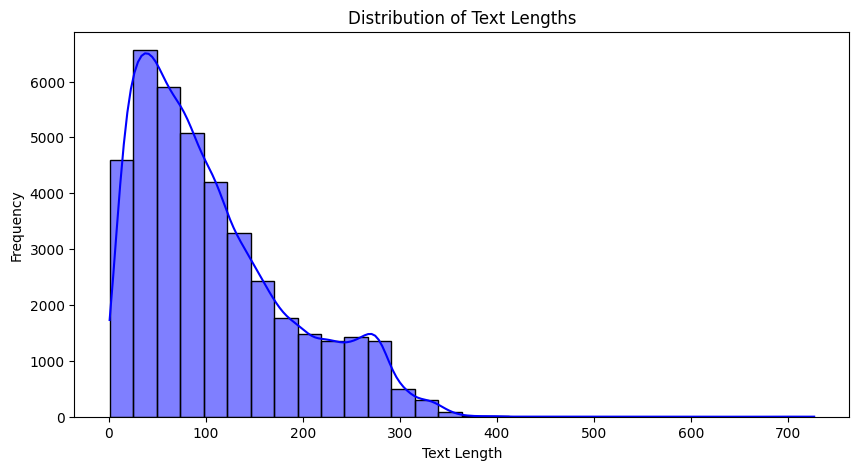

In [ ]:
text_lengths = [len(text) for text in train_data['text']]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(text_lengths, bins=30, kde=True, color='blue')

# Labels and title
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

In [ ]:
X = train_data['cleaned_text']
y = train_data['label']

In [ ]:
tokenizer =Tokenizer( oov_token= oov_tok )
tokenizer.fit_on_texts(X)
word_indx =tokenizer.word_index

sequence = tokenizer.texts_to_sequences(X)
sequence_padded =pad_sequences(sequence, padding= 'post', maxlen= max_length)

In [ ]:
vocab_size =len(word_indx)
vocab_size

17431

In [ ]:
word_indx['spent']

523

In [ ]:
print((X[10]))
print((sequence[10]))
print((sequence_padded[10]))

spent hours making something fun know huge rhandlerr fan maya one favorite characters decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg
[523, 192, 181, 114, 38, 42, 304, 28, 497, 3048, 11, 166, 476, 466, 41, 3529, 150, 536, 2110, 4169, 6010, 109, 331, 5, 7, 3, 9754, 9755, 4170]
[ 523  192  181  114   38   42  304   28  497 3048   11  166  476  466
   41 3529  150  536 2110 4169 6010  109  331    5    7    3 9754 9755
 4170    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  

In [ ]:
joblib.dump(tokenizer, "tokenizer.pkl")

['tokenizer.pkl']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(sequence_padded, y, test_size=0.2, random_state=42)

print('train_sentence length :',len(X_train))
print('train_labels length :',len(y_train))
print('test_sentence length :',len(X_val))
print('test_labels length :',len(y_val))

train_sentence length : 32300
train_labels length : 32300
test_sentence length : 8075
test_labels length : 8075


In [ ]:
model =Sequential([
    Embedding(vocab_size +1, embedding_dim, input_length= max_length),

    Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2 , recurrent_dropout = 0.2)),

    Bidirectional(LSTM(32, dropout = 0.2 , recurrent_dropout = 0.2)),


    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.build(input_shape=(None, max_length))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     2,231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,373,441 (9.05 MB)

 Trainable params: 2,373,441 (9.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history =model.fit(X_train, y_train, batch_size=64, epochs= 10, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 489s 931ms/step - accuracy: 0.7355 - loss: 0.4875 - val_accuracy: 0.9060 - val_loss: 0.2342
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 514s 956ms/step - accuracy: 0.9362 - loss: 0.1608 - val_accuracy: 0.9242 - val_loss: 0.1911
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 498s 950ms/step - accuracy: 0.9644 - loss: 0.0907 - val_accuracy: 0.9350 - val_loss: 0.1792
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 496s 936ms/step - accuracy: 0.9709 - loss: 0.0722 - val_accuracy: 0.9370 - val_loss: 0.1743
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 506s 945ms/step - accuracy: 0.9767 - loss: 0.0582 - val_accuracy: 0.9407 - val_loss: 0.1866
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 458s 907ms/step - accuracy: 0.9783 - loss: 0.0492 - val_accuracy: 0.9413 - val_loss: 0.1870
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 521s 946ms/step - accuracy: 0.9822 - loss: 0.0451 - val_accuracy: 0.9394 - val_loss: 0.2109


In [ ]:
model.save('sentiment_analysis_model.keras')

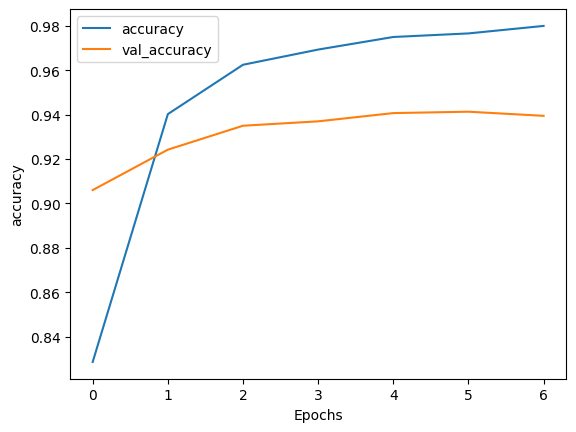

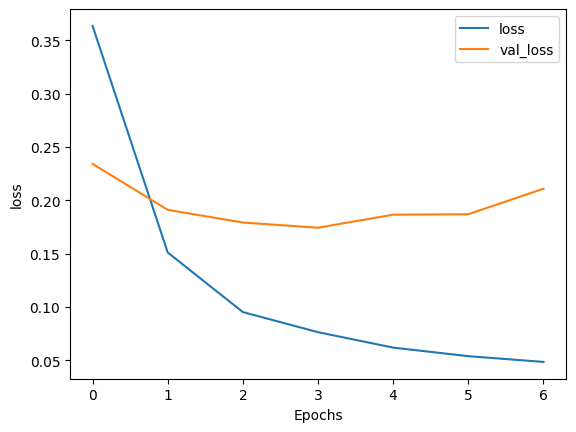

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

253/253 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step


In [ ]:
conf_matrix = confusion_matrix(y_val, y_pred_classes)

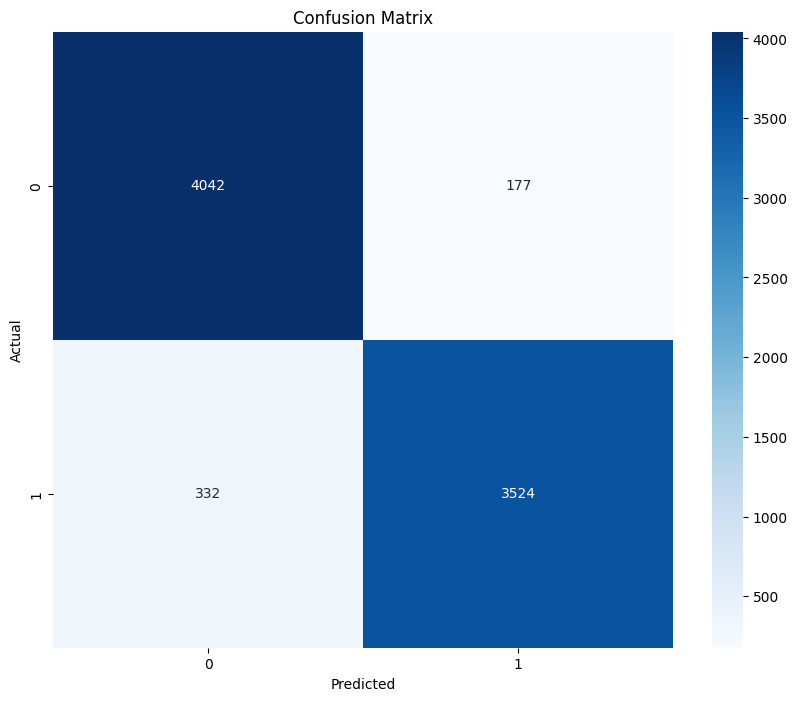

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_pred.max()

np.float32(0.9998746)

In [ ]:
y_pred_classes = np.array(y_pred_classes)

# Convert class labels to strings
target_names = [str(label) for label in np.unique(y)]

# Generate classification report
class_report = classification_report(y_val, y_pred_classes, target_names=target_names)
print('Classification Report:\n', class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      4219
           1       0.95      0.91      0.93      3856

    accuracy                           0.94      8075
   macro avg       0.94      0.94      0.94      8075
weighted avg       0.94      0.94      0.94      8075

